## Imports

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import models,layers 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import pandas as pd
from os import listdir
import os
from tqdm import tqdm

## Metadata

In [37]:
# read CSV files
# TODO use clean dataset
meta_train_df = pd.read_csv("Mush_Me/data/metadata/metadata/DanishFungi2020_train_metadata_DEV.csv", usecols=["image_path", "species"])
meta_test_df = pd.read_csv("Mush_Me/data/metadata/metadata/DanishFungi2020_test_metadata_DEV.csv", usecols=["image_path", "species"])

In [38]:
# merge train and test dataset
meta_df = pd.concat([meta_train_df, meta_test_df])

In [39]:
meta_df = meta_df.dropna()

In [40]:
# clean column image_path from meta_df
meta_df["image_path"] = meta_df["image_path"].map(lambda x: x.replace('/Datasets/DF20/', ''))
meta_df['species'] = meta_df['species'].map(lambda x: x.lower().replace(' ', '_'))

In [41]:
# dictionnary file_name + species_name
meta_df = meta_df.set_index("image_path")
file_name_to_species = meta_df.to_dict()["species"]

In [42]:
file_name_to_species

{'2238546328-30620.jpg': 'ramalina_farinacea',
 '2558871973-53941.jpg': 'hysterium_acuminatum',
 '2238503501-245559.jpg': 'gliophorus_psittacinus',
 '2446759075-197643.jpg': 'lecidella_scabra',
 '2238472345-167057.jpg': 'russula_fragilis',
 '2238512587-322445.jpg': 'tricholoma_lascivum',
 '2237958552-302109.jpg': 'inocybe_asterospora',
 '2238489810-169480.jpg': 'coniophora_arida',
 '2901946385-218331.jpg': 'cuphophyllus_pratensis',
 '2981231346-294710.jpg': 'xylodon_raduloides',
 '2898627392-366751.jpg': 'chlorophyllum_olivieri',
 '2417207399-118782.jpg': 'clavulina_rugosa',
 '2238584938-38711.jpg': 'mycena_vitilis',
 '2238573692-333898.jpg': 'russula_faginea',
 '2981245403-72260.jpg': 'clavulina_coralloides',
 '2981230448-71609.jpg': 'exidia_recisa',
 '2238545918-30519.jpg': 'tricholoma_argyraceum',
 '2238446728-16962.jpg': 'hortiboletus_bubalinus',
 '2248039505-188445.jpg': 'lactarius_tabidus',
 '2238582681-260752.jpg': 'schizophyllum_amplum',
 '2238515225-173620.jpg': 'peziza_varia'

## Creating Species directory

In [43]:
list_picture = os.listdir("./Mush_Me/data/raw_data/model_test/")
list_picture

['2883254345-215221.jpg',
 '2238489858-21221.jpg',
 '2238514314-99221.jpg',
 '2238547886-253221.jpg',
 '2862696427-361221.jpg',
 '2238576331-259221.jpg',
 '2332527680-190221.jpg',
 '2632343307-356221.jpg',
 '2244194095-188221.jpg',
 '2238514203-25221.jpg',
 '2816373345-208221.jpg',
 '2238561349-108221.jpg',
 '2868479522-363221.jpg',
 '2238564252-332221.jpg',
 '2238481655-168221.jpg',
 '2460546892-349221.jpg',
 '2427873478-47221.jpg',
 '2864911309-138221.jpg',
 '2238135391-229221.jpg',
 '2417207767-342221.jpg',
 '2421821296-267221.jpg',
 '2989734335-222221.jpg',
 '2452379662-348221.jpg',
 '2427874572-345221.jpg',
 '2238085629-80221.jpg',
 '2238465425-166221.jpg',
 '2847216319-135221.jpg',
 '2238488391-243221.jpg',
 '2542590818-53221.jpg',
 '2446761130-198221.jpg',
 '2460547570-200221.jpg',
 '2332527484-116221.jpg',
 '2238566525-183221.jpg',
 '2238179604-83221.jpg',
 '2238568993-35221.jpg',
 '2558873018-54221.jpg',
 '2986450344-147221.jpg',
 '2383042503-43221.jpg',
 '2238530996-250221.jp

In [30]:
pwd

'/Users/charlottedebelay/code/hadri96/Mush_Me'

In [31]:
!mkdir Mush_Me/data/image_dataset

mkdir: Mush_Me/data/image_dataset: File exists


In [50]:
# removing corrupted images

from struct import unpack
import os

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

bads = []
for img in tqdm(list_picture):
  path = f'./Mush_Me/data/raw_data/model_test/{img}'
  image = JPEG(path) 
  try:
    image.decode()   
  except:
    bads.append(path)


for name in bads:
    os.remove(name)

100%|██████████| 372/372 [00:00<00:00, 1469.83it/s]


In [51]:
# creating species directory

src = './Mush_Me/data/raw_data/model_test'
dest = 'Mush_Me/data/image_dataset'

for picture in list_picture:
    if '.jpg' in picture:
        try:
            species = meta_df.loc[picture].species
        except:
            continue
        !mkdir -p {dest}/{species}
        !mv {src}/{picture} {dest}/{species}

mv: rename ./Mush_Me/data/raw_data/model_test/2558873018-54221.jpg to Mush_Me/data/image_dataset/pithya_vulgaris/2558873018-54221.jpg: No such file or directory


## Generate image dataset

In [52]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dest, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 306 files belonging to 257 classes.


In [54]:
class_names = image_dataset.class_names

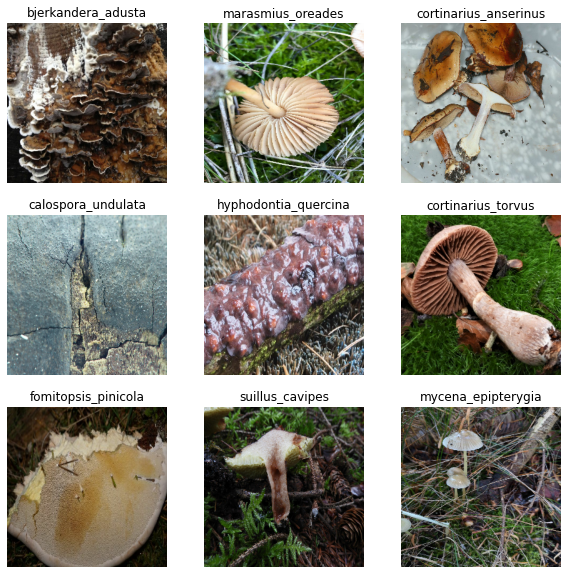

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in image_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Augmentation
WORK IN PROGRESS
